In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import sys

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax
from keras.callbacks import EarlyStopping
from datetime import datetime as dt
import time
import math

#スタート時間を保持
starttime = time.time()

# 定数の定義
# HIGH  = 0
# LOW   = 1
# CLOSE = 2

# 学習の設定
l_of_s         = 5
n_next         = 10
in_out_neurons = 1
hidden_neurons = 512

# 学習用データを抽出する関数
def _load_data(data, n_prev=10, n_next=1, flag=True):
    docX, docY = [], []
    for i in range(n_prev, len(data)-n_next):
        #起点の箇所からn_prevだけ戻った日数分をデータとする
        docX.append(data.iloc[i-n_prev:i].as_matrix())
        #起点の翌日からn_next日数分進んだデータのmax or minをyデータとする
        if flag == True:
        # 最大値
            docY.append(max(data.iloc[i+1:i+n_next].as_matrix()))
        elif flag == False:
        # 最小値
            docY.append(min(data.iloc[i+1:i+n_next].as_matrix()))

    alsX = numpy.array(docX)
    alsY = numpy.array(docY)
    return alsX, alsY

def min_max(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result


Using TensorFlow backend.


In [2]:
import urllib.request

#ダウンロードする通貨ペア
#https://stooq.com/q/d/?s=usdjpy
#ついでにsekjpy、nokjpy、mxnjpy、sgdjpyとかもありますが、
#2000/01/01からデータがない（あるけど、しばらくopen/high/low/closeがすべて一緒)ので
#ここには７通貨ペアしか記載しておりません。日付とか調整して通貨ペアを増やしてみても
#いいと思います
#currency_pair = 'usdjpy'
#currency_pair = 'eurjpy'
#currency_pair = 'gbpjpy'
#currency_pair = 'audjpy'
#currency_pair = 'cadjpy'
currency_pair = 'chfjpy'
#currency_pair = 'nzdjpy'
#currency_pair = 'sekjpy'
#currency_pair = 'nokjpy'

#スタート日付
start_day     = "20030101"
#終了日を今日に指定
url           = "https://stooq.com/q/d/l/?s=" + currency_pair + \
                "&d1=" + start_day + "&d2=" + dt.today().strftime("%Y%m%d") + "&i=d"
file_name     = currency_pair + '_d.csv'
#取得して、ファイルに保存(よくよく考えると保存しなくてもいいな)
urllib.request.urlretrieve(url, file_name)


('chfjpy_d.csv', <http.client.HTTPMessage at 0x1f3be0f8b00>)

In [3]:
# FXデータの読み込み
data = None
data = pandas.read_csv(file_name)
data.columns = ['date', 'open', 'high', 'low', 'close']
data['date'] = pandas.to_datetime(data['date'], format='%Y-%m-%d')

#train開始終了、test開始終了日を設定
#データは2001/01/01からとっていますが、さかのぼって調査する関係上
#20001/01/01からにしています。また買い目対象の調査としてtest_end_dayよりも
#後の日も参照するためtest_end_dayの取得するデータにはしないでください。
#trainの終了日とtestの開始日が連続していますが、連続させなくても動作するか
#検証していません。注意してください
train_start_day   = dt.strptime('2015-01-01', '%Y-%m-%d')
train_end_day     = dt.strptime('2015-12-31', '%Y-%m-%d')
test_start_day    = dt.strptime('2016-01-01', '%Y-%m-%d')
test_end_day      = dt.strptime('2016-12-31', '%Y-%m-%d')
train_start_count = -1
train_end_count   = -1
test_start_count  = -1
test_end_count    = -1

#train/testの開始終了日の配列の場所を調査
for i in range(len(data['date'])):
    if train_start_count == -1 and data['date'][i] >= train_start_day:
        train_start_count = i
    if train_end_count == -1 and data['date'][i] >= train_end_day:
        train_end_count = i
    if test_start_count == -1 and data['date'][i] >= test_start_day:
        test_start_count = i
    if test_end_count == -1 and data['date'][i] >= test_end_day:
        test_end_count = i
        break

#前にl_of_s日分、後ろにn_next分日数が必要なので
#チェック。足りない場合は中止。これを考慮に入れて
#train/testの開始終了日を設定してください
if train_start_count - l_of_s < 0 or \
    test_end_count + n_next > len(data['date']):
    
    print("data range over")
    sys.exit()
    
print('Train Start: ' + str(train_start_count))
print('Train End  : ' + str(train_end_count))
print('Test  Start: ' + str(test_start_count))
print('Test  End  : ' + str(test_end_count))

up_down           = []
up_count          = 0
down_count        = 0
even_count        = 0
#up/downの割合
check_treshhold   = 0.666
loop_flag         = True

#
check_add_percent = 0.0020
check_percent     = 0.02
if min(data.loc[:, 'low']) > 150:
    check_add_percent = 0.20
    check_percent     = 2.0
elif min(data.loc[:, 'low']) > 30:
    check_add_percent = 0.020
    check_percent     = 0.2
    
#close_open_diff = numpy.array([])
#for i in range(train_start_count, test_end_count):
#    close_open_diff = numpy.append(close_open_diff, numpy.array(data.loc[i-1, 'close'] - data.loc[i, 'open']))
#print('Close-Open Diff:' + str(close_open_diff.mean()) + ' ' + str(close_open_diff.std()))
#up_c_o_diff   = close_open_diff.mean() + close_open_diff.std() * 2
#down_c_o_diff = close_open_diff.mean() - close_open_diff.std() * 2
#c_o_d_remove_count = 0
#for i in range(train_start_count, test_end_count):
#    if data.loc[i-1, 'close'] - data.loc[i, 'open'] >= up_c_o_diff or \
#        data.loc[i-1, 'close'] - data.loc[i, 'open'] <= down_c_o_diff:
#        c_o_d_remove_count += 1
#print("c_o_d_remove_count:" + str(c_o_d_remove_count))

while loop_flag:
    up_count = 0
    down_count = 0
    even_count = 0
    check_percent += check_add_percent
    for i in range(train_start_count, test_end_count):
        #起点の日の翌日のopenの値
        open_value = data.loc[i+1, 'open']
        #起点の日から翌日からn_next日数分のhighの最大値
        max_value = max(data.loc[i+1:i+n_next, 'high'])
        #起点の日から翌日からn_next日数分のlowの最小値
        min_value = min(data.loc[i+1:i+n_next, 'low'])
        #ここは起点の日の翌日のopenの値と起点の日の翌日から
        #n_next日数分のhighの最高値かlowの最小値が規定の値上に
        #差が広がったカウントを調べる。これで上がった・下がったを
        #回数を調べる
        
        if abs(max_value - open_value) >= check_percent and \
            abs(open_value - min_value) < check_percent:
            up_count += 1
        elif abs(open_value - min_value) >= check_percent and \
            abs(max_value - open_value) < check_percent:
            down_count += 1  
        else:
            even_count += 1
    
    #(上がった日+下がった日)/全体の日数でcheck_treshholdを超えたか調べる
    #超えていればその値をベースにする
    print('up_count : '+ str(up_count) + ' down_count : ' + str(down_count) + ' even_count :' + str(even_count))
    print('(U+D)/(U+D+E): ' + str(math.floor((up_count + down_count) / \
                                             (up_count + down_count +even_count) * 100)) + '%')    
    if (up_count + down_count) / (up_count + down_count +even_count) > check_treshhold:
        break

#上がった・下がったの判定するための数字（もっと言うと円がどれだけ動いたか）
print('p            : ' + str(check_percent))
print("UP   COUNT   : " + str(up_count))
print("DOWN COUNT   : " + str(down_count))
print("EVNE COUNT   : " + str(even_count))
print('(U+D)/(U+D+E): ' + str(math.floor((up_count + down_count) / \
                                         (up_count + down_count +even_count) * 100)) + '%')    

#sys.exit()
#上がった・下がったの判定用
#ここではtestの範囲のみ取得
print("Testデータ生成")
print(test_start_count)

for i in range(test_start_count, test_end_count):
    open_value = data.loc[i+1, 'open']
    close_value = data.loc[i, 'open']
    #起点の日から翌日からn_next日数分のhighの最大値
    max_value = max(data.loc[i+1:i+n_next, 'high'])
    #起点の日から翌日からn_next日数分のlowの最小値
    min_value = min(data.loc[i+1:i+n_next, 'low'])
    #ここは起点の日の翌日のopenの値と起点の日の翌日から
    #n_next日数分のhighの最高値かlowの最小値が規定の値上に
    #差が広がったカウントを調べる。これで上がった・下がったを
    #回数を調べる
    if abs(max_value - open_value) >= check_percent and \
        abs(open_value - min_value) < check_percent:
        up_down.append(1)
    elif abs(open_value - min_value) >= check_percent and \
        abs(max_value - open_value) < check_percent:
        up_down.append(-1)
    else:
        up_down.append(0)

#正規化
max_value = max(data['high'])
min_value = min(data['low'])
average_value = (max_value+min_value)/2
diff_value = max_value - average_value
print ('max: ' + str(max_value))
print ('min: ' + str(min_value))
print ('ave: ' + str(average_value))
print ('dif: ' + str(diff_value))

#for i in range(len(data['high'].index)):
#    data.loc[i, 'high'] = (data.loc[i, 'high'] - average_value) / diff_value
#    data.loc[i, 'low']  = (data.loc[i, 'low'] - average_value) / diff_value
#    data.loc[i, 'open'] = (data.loc[i, 'open'] - average_value) / diff_value
#    data.loc[i, 'close'] = (data.loc[i, 'close'] - average_value) / diff_value

data = data.sort_values(by='date')
data = data.reset_index(drop=True)
data = data.loc[:, ['date', 'open','high', 'low', 'close']]

#グラフ化
#plt.plot(data['date'], data['high'])
#plt.plot(data['date'], data['low'])
#plt.show()

#sys.exit()

Train Start: 3113
Train End  : 3371
Test  Start: 3372
Test  End  : 3630
up_count : 34 down_count : 34 even_count :449
(U+D)/(U+D+E): 13%
up_count : 38 down_count : 38 even_count :441
(U+D)/(U+D+E): 14%
up_count : 38 down_count : 42 even_count :437
(U+D)/(U+D+E): 15%
up_count : 43 down_count : 45 even_count :429
(U+D)/(U+D+E): 17%
up_count : 45 down_count : 48 even_count :424
(U+D)/(U+D+E): 17%
up_count : 49 down_count : 51 even_count :417
(U+D)/(U+D+E): 19%
up_count : 51 down_count : 57 even_count :409
(U+D)/(U+D+E): 20%
up_count : 55 down_count : 65 even_count :397
(U+D)/(U+D+E): 23%
up_count : 58 down_count : 73 even_count :386
(U+D)/(U+D+E): 25%
up_count : 63 down_count : 74 even_count :380
(U+D)/(U+D+E): 26%
up_count : 67 down_count : 76 even_count :374
(U+D)/(U+D+E): 27%
up_count : 73 down_count : 80 even_count :364
(U+D)/(U+D+E): 29%
up_count : 74 down_count : 83 even_count :360
(U+D)/(U+D+E): 30%
up_count : 75 down_count : 87 even_count :355
(U+D)/(U+D+E): 31%
up_count : 77 down

High Fit
Train on 232 samples, validate on 26 samples
Epoch 1/100
 - 3s - loss: 0.0342 - acc: 0.0345 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 2/100
 - 2s - loss: 0.0141 - acc: 0.0259 - val_loss: 3.3818e-04 - val_acc: 0.0000e+00
Epoch 3/100
 - 4s - loss: 0.0140 - acc: 0.0345 - val_loss: 4.2239e-04 - val_acc: 0.0000e+00
High Predict


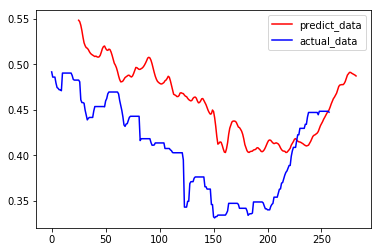

Low Fit
Train on 232 samples, validate on 26 samples
Epoch 1/100
 - 3s - loss: 0.0214 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 2/100
 - 2s - loss: 0.0049 - acc: 0.0000e+00 - val_loss: 0.0100 - val_acc: 0.0000e+00
Low Predict


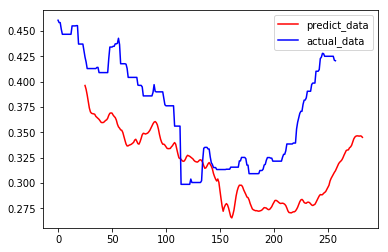

In [4]:
# データ準備
#ここではhigh/lowのtrain/testの４つを整備
#配列的にl_of_sとn_next分の前後にとる
X_high_train, y_high_train = _load_data(data[['high']].iloc[train_start_count-l_of_s:train_end_count+n_next], \
                                        l_of_s, n_next, True)
X_high_test , y_high_test  = _load_data(data[['high']].iloc[test_start_count-l_of_s:test_end_count+n_next], \
                                        l_of_s, n_next, True)
X_low_train , y_low_train  = _load_data(data[['low']].iloc[train_start_count-l_of_s:train_end_count+n_next], \
                                        l_of_s, n_next, False)
X_low_test  , y_low_test   = _load_data(data[['low']].iloc[test_start_count-l_of_s:test_end_count+n_next], \
                                        l_of_s, n_next, False)


X_high_train = (X_high_train-min_value)/(max_value-min_value)
y_high_train = (y_high_train-min_value)/(max_value-min_value)
X_high_test = (X_high_test-min_value)/(max_value-min_value)
y_high_test = (y_high_test-min_value)/(max_value-min_value)
X_low_train = (X_low_train-min_value)/(max_value-min_value)
y_low_train = (y_low_train-min_value)/(max_value-min_value)
X_low_test = (X_low_test-min_value)/(max_value-min_value)
y_low_test = (y_low_test-min_value)/(max_value-min_value)


#
# ニューラルネットの定義
#LSTMの定義/high/lowの両方を別々に保持したけど
#modeは共用してfitだけ違えればいい気がしないでもない
high_model = Sequential()
high_model.add(LSTM(hidden_neurons, \
          batch_input_shape=(None, X_high_train.shape[1], in_out_neurons), \
          return_sequences=False))
# 2018/1/24 Kitamura Add Start ドロップアウト率の定義
high_model.add(Dropout(0.1))
# 2018/1/24 Kitamura Add End
high_model.add(Dense(in_out_neurons))
high_model.add(Activation("linear"))
#high_model.add(Activation("sigmoid"))
#optimizer = SGD(lr=0.5, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#optimizer = Adadelta(lr=5.0)
epochs = 100

callbacks = []
callbacks.append(EarlyStopping("val_loss", patience=1))
high_model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['accuracy'])
#high_model.add(Activation("sigmoid"))
#high_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])



low_model = Sequential()
low_model.add(LSTM(hidden_neurons, \
          batch_input_shape=(None, X_low_train.shape[1], in_out_neurons), \
          return_sequences=False))
# 2018/1/24 Kitamura Add Start ドロップアウト率の定義
low_model.add(Dropout(0.1))
# 2018/1/24 Kitamura Add End
low_model.add(Dense(in_out_neurons))
low_model.add(Activation("linear"))
#low_model.add(Activation("sigmoid"))
low_model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['accuracy'])
#low_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])


print("High Fit")
# 学習
high_result = high_model.fit(X_high_train, y_high_train, batch_size=10, epochs=epochs, validation_split=0.1, verbose=2, callbacks=callbacks)

# modelに学習させた時の変化の様子をplot
x = range(epochs)
#plt.plot(x, high_result.history['acc'], label="acc")
#plt.title("accuracy")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()

#plt.plot(x, high_result.history['loss'], label="loss")
#plt.title("loss")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()

#score = high_model.evaluate(X_high_test, y_high_test)
#print("\nLoss:", score[0], "Accuracy:", score[1])

print("High Predict")
high_predicted = high_model.predict(X_high_test)

plt.figure()
plt.plot(range(25,len(high_predicted)+25),high_predicted, color="r", label="predict_data")
plt.plot(range(0, len(y_high_test)), y_high_test, color="b", label="actual_data")
plt.legend()
plt.show()

#sys.exit()

# テスト結果表示
#high_predicted = high_model.predict(X_high_test)

# 2018/1/24 Kitamura Add Start
# 結果のプロット
#high_result = pandas.DataFrame(high_predicted)
#high_result.columns = ['predict']
#high_result['actual'] = y_high_test
#high_result.plot()
#plt.show()
# 2018/1/24 Kitamura Add End

print("Low Fit")
# 学習
low_result = low_model.fit(X_low_train, y_low_train, batch_size=10, epochs=epochs, validation_split=0.1, verbose=2, callbacks=callbacks)
#low_model.fit(X_low_train, y_low_train, batch_size=100, epochs=1000, validation_split=0.0)

# modelに学習させた時の変化の様子をplot
x = range(epochs)
#plt.plot(x, low_result.history['acc'], label="acc")
#plt.title("accuracy")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()

#plt.plot(x, low_result.history['loss'], label="loss")
#plt.title("loss")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()

#score = high_model.evaluate(X_high_test, y_high_test)
#print("\nLoss:", score[0], "Accuracy:", score[1])

print("Low Predict")
low_predicted = low_model.predict(X_low_test)

plt.figure()
plt.plot(range(25,len(low_predicted)+25),low_predicted, color="r", label="predict_data")
plt.plot(range(0, len(y_low_test)), y_low_test, color="b", label="actual_data")
plt.legend()
plt.show() 

# テスト結果表示
#low_predicted = low_model.predict(X_low_test)

# 2018/1/24 Kitamura Add Start
# 結果のプロット
#low_result = pandas.DataFrame(low_predicted)
#low_result.columns = ['predict']
#low_result['actual'] = y_low_test
#low_result.plot()
#plt.show()
# 2018/1/24 Kitamura Add End




In [5]:
#high/lowの予想最大/最小値のグラフ（小さくてわからない）
#result = pandas.DataFrame(high_predicted)
#result.columns = ['high_predict']
#result['low_predict'] = low_predicted
#result.plot()
#plt.show()

#
pre_check = []
temp_check = []
temp_close_open = []
temp_close_open_up_win = []
temp_close_open_up_lost = []
temp_close_open_down_win = []
temp_close_open_down_lost = []

#使わないデータも保持しているが
#予想したHighの最大値とLowの最小値を起点の日の翌日のOpenの
#と比較し、最初sに決定した差よりも大きい場合は上がり・下がりと
#判断する
#ただし、同時超えた場合はどちらが先に上がるか不明なためカウントしていない
#もしかすると
print("Predictデータ検証")
for i in range(len(y_high_test)):
    
    high_temp = ((max_value*high_predicted[i])-(min_value*high_predicted[i]))+min_value
    low_temp = ((max_value*low_predicted[i])-(min_value*low_predicted[i]))+min_value
    open_temp = data.loc[i+test_start_count+1, 'open']
    close_temp = data.loc[i+test_start_count, 'close']
    #high_temp = high_predicted[i] * diff_value + average_value
    #low_temp  = low_predicted[i] * diff_value + average_value
    #open_temp = data.loc[i+test_start_count+1, 'open'] * diff_value + average_value
    #close_temp = data.loc[i+test_start_count, 'close'] * diff_value + average_value

    # Kitamura modify check_treshhold -> check_percent
    if high_temp - close_temp >= check_percent and \
        close_temp - low_temp < check_percent:
        pre_check.append(1)
        temp_check.append(high_temp - open_temp)
        temp_close_open.append(abs(close_temp - open_temp))

    elif close_temp- low_temp >= check_percent and \
        high_temp - close_temp < check_percent:
        pre_check.append(-1)
        temp_check.append(low_temp - open_temp)
        temp_close_open.append(abs(close_temp - open_temp))
    
    #elif high_temp - open_temp >= check_treshhold and \
    #    open_temp- low_temp >= check_treshhold:
        
    #    if high_temp - open_temp > open_temp- low_temp:
    #        pre_check.append(1)
    #        temp_check.append(high_temp - open_temp)
    #    elif high_temp - open_temp < open_temp- low_temp:
    #        pre_check.append(-1)
    #        temp_check.append(low_temp - open_temp)
    #    else:
    #        pre_check.append(0)
    #        temp_check.append(0)

    #if high_temp - open_temp >= check_treshhold and \
    #    open_temp - low_temp < check_treshhold and \
    #    close_temp - open_temp <= up_c_o_diff and \
    #    close_temp - open_temp >= down_c_o_diff:
    #    pre_check.append(1)
    #    temp_check.append(high_temp - open_temp)

    #elif open_temp- low_temp >= check_treshhold and \
    #    high_temp - open_temp < check_treshhold and \
    #    close_temp - open_temp <= up_c_o_diff and \
    #    close_temp - open_temp >= down_c_o_diff:
    #    pre_check.append(-1)
    #    temp_check.append(low_temp - open_temp)

    else:
        pre_check.append(0)
        temp_check.append(0)

up_ok_count = 0
up_ng_count = 0
up_ev_count = 0
down_ok_count = 0
down_ng_count = 0
down_ev_count = 0
# Kitamura Add Start
predict_ok_count = 0
predict_ng_count = 0
predict_ev_count = 0
# Kitamura Add End
high_win = numpy.array([])
high_lost = numpy.array([])
low_win  = numpy.array([])
low_lost  = numpy.array([])

# Kitamua modify Start
#for i in range(len(pre_check)):
#    if pre_check[i] == 1:
#        if up_down[i] == pre_check[i]:
#            up_ok_count += 1
#            high_win = numpy.append(high_win, numpy.array(temp_check[i]))
#        elif up_down[i] != pre_check[i] and up_down[i] == -1:
#            up_ng_count += 1
#            high_lost = numpy.append(high_lost, numpy.array(temp_check[i]))
#        else:
#            up_ev_count += 1
#            
#    elif pre_check[i] == -1:
#        if up_down[i] == pre_check[i]:
#            down_ok_count += 1
#            low_win = numpy.append(low_win, numpy.array(temp_check[i]))
#        elif up_down[i] != pre_check[i] and up_down[i] == 1:
#            down_ng_count += 1
#            low_lost = numpy.append(low_lost, numpy.array(temp_check[i]))
#        else:
#            down_ev_count += 1
for i in range(len(pre_check)):
    if up_down[i] == pre_check[i]:
        predict_ok_count += 1 
    else:
        predict_ng_count += 1

# 勝率測定 判の厳しさ:低
#    if pre_check[i] == 1:
#        if up_down[i] == pre_check[i]:
#            up_ok_count += 1
#            high_win = numpy.append(high_win, numpy.array(temp_check[i]))
#        elif up_down[i] != pre_check[i] and up_down[i] == -1:
#            up_ng_count += 1
#            high_lost = numpy.append(high_lost, numpy.array(temp_check[i]))
#        else:
#            up_ev_count += 1
#
#    elif pre_check[i] == -1:
#        if up_down[i] == pre_check[i]:
#            down_ok_count += 1
#            low_win = numpy.append(low_win, numpy.array(temp_check[i]))
#        elif up_down[i] != pre_check[i] and up_down[i] == 1:
#            down_ng_count += 1
#            low_lost = numpy.append(low_lost, numpy.array(temp_check[i]))
#        else:
#            down_ev_count += 1

# 勝率測定 判の厳しさ:中            
    if pre_check[i] == 1:
        if up_down[i] == pre_check[i]:
            up_ok_count += 1
            high_win = numpy.append(high_win, numpy.array(temp_check[i]))
        elif data.loc[i+test_start_count, 'close'] < data.loc[i+test_start_count+n_next, 'close']:
            up_ev_count += 1
        else:
            up_ng_count += 1
            high_lost = numpy.append(high_lost, numpy.array(temp_check[i]))
            
    elif pre_check[i] == -1:
        if up_down[i] == pre_check[i]:
            down_ok_count += 1
            low_win = numpy.append(low_win, numpy.array(temp_check[i]))
        elif data.loc[i+test_start_count, 'close'] > data.loc[i+test_start_count+n_next, 'close']:
            down_ev_count += 1
        else:
            down_ng_count += 1
            low_lost = numpy.append(low_lost, numpy.array(temp_check[i]))
    else:
        predict_ev_count += 1        
# Kitamua modify End


print('==========')
print('UP:')
print(' WIN  :' + str(up_ok_count))
print(' LOST :' + str(up_ng_count))
print(' DRAW :' + str(up_ev_count))
#print(' WIN RATE :' + str(math.floor((up_ok_count)/(up_ok_count+up_ng_count)*100)) + '%')
print(' WIN RATE :' + str(math.floor((up_ok_count+up_ev_count)/(up_ok_count+up_ng_count+up_ev_count)*100)) + '%')
print('DOWN:')
print(' WIN  :' + str(down_ok_count))
print(' LOST :' + str(down_ng_count))
print(' DRAW :' + str(down_ev_count))
#print(' WIN RATE :' + str(math.floor((down_ok_count)/(down_ok_count+down_ng_count)*100)) + '%')
print(' WIN RATE :' + str(math.floor((down_ok_count+down_ev_count)/(down_ok_count+down_ng_count+down_ev_count)*100)) + '%')
# Kitamura Add Start
print('PREDICT:')
print(' OK  :' + str(predict_ok_count))
print(' NG  :' + str(predict_ng_count))
print(' OK RATE :' + str(math.floor((predict_ok_count/(predict_ok_count+predict_ng_count))*100)) + '%')
# Kitamura Add En
#print('---------')
#print('UP ')
#print('  WIN  :' + str(high_win.mean()) + ' ' + str(high_win.std()))
#print('  LOST  :' + str(high_lost.mean()) + ' ' + str(high_lost.std()))
#print('DOWN ')
#print('  WIN  :' + str(low_win.mean()) + ' ' + str(low_win.std()))
#print('  LOST  :' + str(low_lost.mean()) + ' ' + str(low_lost.std()))


print(str(math.floor(time.time() - starttime)) + "s")

Predictデータ検証
UP:
 WIN  :0
 LOST :0
 DRAW :0


ZeroDivisionError: division by zero